# flatten 4d (lat, lon, date, level) output data to 2d (record, level)

In [1]:
import numpy as np
import xarray as xr
import re

In [2]:
# Name of input Netcdf file
input_directory = '/geos/u73/msadiq/satellite/oco-2/'
output_directory = input_directory

name_nc_in = 'OCO2_extract.nc'
input_file = input_directory + name_nc_in # full name

# Name of output netCDF file
output_file = output_directory + '2d_' + name_nc_in

In [4]:
ds = xr.open_dataset(input_file)
ds
#ds['xco2_averaging_kernel'].isel(levels=19,time=0).plot()

<xarray.Dataset>
Dimensions:                (date: 31, lat: 91, lev: 20, lon: 144)
Coordinates:
  * date                   (date) datetime64[ns] 2018-03-01 ... 2018-03-31
  * lev                    (lev) float32 1e-04 0.05263158 ... 0.94736844 1.0
  * lat                    (lat) float64 -90.0 -88.0 -86.0 ... 86.0 88.0 90.0
  * lon                    (lon) float64 -180.0 -177.5 -175.0 ... 175.0 177.5
Data variables:
    xco2_averaging_kernel  (date, lev, lat, lon) float32 ...
    xco2                   (date, lat, lon) float32 ...
    psurf                  (date, lat, lon) float32 ...

In [5]:
varnames = list(ds.data_vars.keys())  # Get a list of variable names. The expression is a bit cumbersome. Just copy and paste it for now.
nvar = len(varnames)  # how many elements in the list?
varnames

['xco2_averaging_kernel', 'xco2', 'psurf']

In [7]:
nm_lev = len(ds.coords['lev'])
nm_lon = len(ds.coords['lon'])
nm_lat = len(ds.coords['lat'])
nm_days = len(ds.coords['date'])

record = range(nm_lon * nm_lat * nm_days)
record

range(0, 406224)

In [10]:
# 2d data array to store flattened data
foo_2d = xr.DataArray(data = 0,
                      dims=('record', 'levels'),
                      coords=[record, ds.coords['lev']])
foo_2d = foo_2d.astype(dtype = 'float32')
# 1d data array to store flattened data
foo_1d = xr.DataArray(data = 0,
                      dims=('record'),
                      coords={record})
foo_1d = foo_1d.astype(dtype = 'float32')

# dataset to store following dataarrays
ds_output = foo_2d.to_dataset(name = 'xco2')
ds_output = ds_output.astype(dtype = 'float32')

In [14]:
flat = ds['xco2_averaging_kernel'][:,0,:,:].to_dataframe()
# flatten a variable at one level
flat.reset_index(inplace=True) 
# get indices from this to prepare output coordinates

In [15]:
flat

,date,lat,lon,lev,xco2_averaging_kernel
0,2018-03-01,-90.0,-180.0,0.0001,0.0
1,2018-03-01,-90.0,-177.5,0.0001,0.0
2,2018-03-01,-90.0,-175.0,0.0001,0.0
3,2018-03-01,-90.0,-172.5,0.0001,0.0
4,2018-03-01,-90.0,-170.0,0.0001,0.0
...,...,...,...,...,...
406219,2018-03-31,90.0,167.5,0.0001,0.0
406220,2018-03-31,90.0,170.0,0.0001,0.0
406221,2018-03-31,90.0,172.5,0.0001,0.0
406222,2018-03-31,90.0,175.0,0.0001,0.0


In [16]:
lat = xr.DataArray(0, coords=[record], dims=['record'])
lon = xr.DataArray(0, coords=[record], dims=['record'])
date = xr.DataArray(0, coords=[record], dims=['record'])
lat.values = flat['lat']
lon.values = flat['lon']
date.values = flat['date']
ds_output['lat'] = lat
ds_output['lon'] = lon
ds_output['date'] = date
ds_output

<xarray.Dataset>
Dimensions:  (levels: 20, record: 406224)
Coordinates:
  * record   (record) int64 0 1 2 3 4 5 ... 406219 406220 406221 406222 406223
  * levels   (levels) float32 1e-04 0.05263158 0.10526316 ... 0.94736844 1.0
Data variables:
    xco2     (record, levels) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    lat      (record) float64 -90.0 -90.0 -90.0 -90.0 ... 90.0 90.0 90.0 90.0
    lon      (record) float64 -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5
    date     (record) datetime64[ns] 2018-03-01 2018-03-01 ... 2018-03-31

In [18]:
for ivar in varnames:
    print(ivar)
    
    if len(ds[ivar].dims) == 4:
        for ilev in range(nm_lev):
            flat = ds[ivar][:,ilev,:,:].to_dataframe() # flatten a variable at one level
            foo_2d[:,ilev] = flat[ivar].values # store output to a dataarray
        ds_output[ivar] = foo_2d.copy() # store dataarray to dataset
    
    else:
        flat = ds[ivar].to_dataframe()
        foo_1d.values = flat[ivar].values
        ds_output[ivar] = foo_1d.copy() # store dataarray to dataset

xco2_averaging_kernel
xco2
psurf


In [19]:
ds_output

<xarray.Dataset>
Dimensions:                (levels: 20, record: 406224)
Coordinates:
  * record                 (record) int64 0 1 2 3 ... 406221 406222 406223
  * levels                 (levels) float32 1e-04 0.05263158 ... 0.94736844 1.0
Data variables:
    xco2                   (record) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    lat                    (record) float64 -90.0 -90.0 -90.0 ... 90.0 90.0 90.0
    lon                    (record) float64 -180.0 -177.5 -175.0 ... 175.0 177.5
    date                   (record) datetime64[ns] 2018-03-01 ... 2018-03-31
    xco2_averaging_kernel  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    psurf                  (record) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [48]:
ds_output.attrs['comment'] = 'flattened from 4d NetCDF file, after extracted from OCO2'

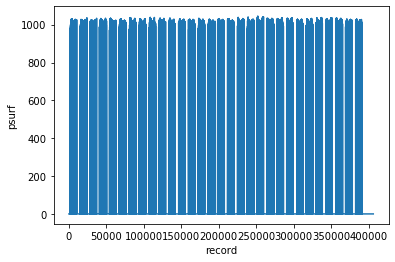

In [21]:
ds_output.psurf.plot()

In [22]:
ds_output.to_netcdf(path=output_file)